Population=300:   0%|          | 0/60 [00:00<?, ?it/s]

Completed: Pop=300, Select=0.3333333333333333, Mutate=0.1 - Final Fitness=366.5953158056469
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.15 - Final Fitness=367.3160349547444
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.05 - Final Fitness=359.6980645722041
Completed: Pop=300, Select=0.5, Mutate=0.05 - Final Fitness=367.3253328698948
Completed: Pop=300, Select=0.5, Mutate=0.15 - Final Fitness=363.8350826843348
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.05 - Final Fitness=365.55842923483533
Completed: Pop=300, Select=0.5, Mutate=0.1 - Final Fitness=362.4036665902797
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.1 - Final Fitness=363.86417194980453
Completed: Pop=300, Select=0.75, Mutate=0.05 - Final Fitness=370.3562066707842
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.15 - Final Fitness=362.95802644443904
Completed: Pop=300, Select=0.75, Mutate=0.1 - Final Fitness=363.2537068955724
Completed: Pop=300, Select=0.75, Mutate=0.15 - Fina

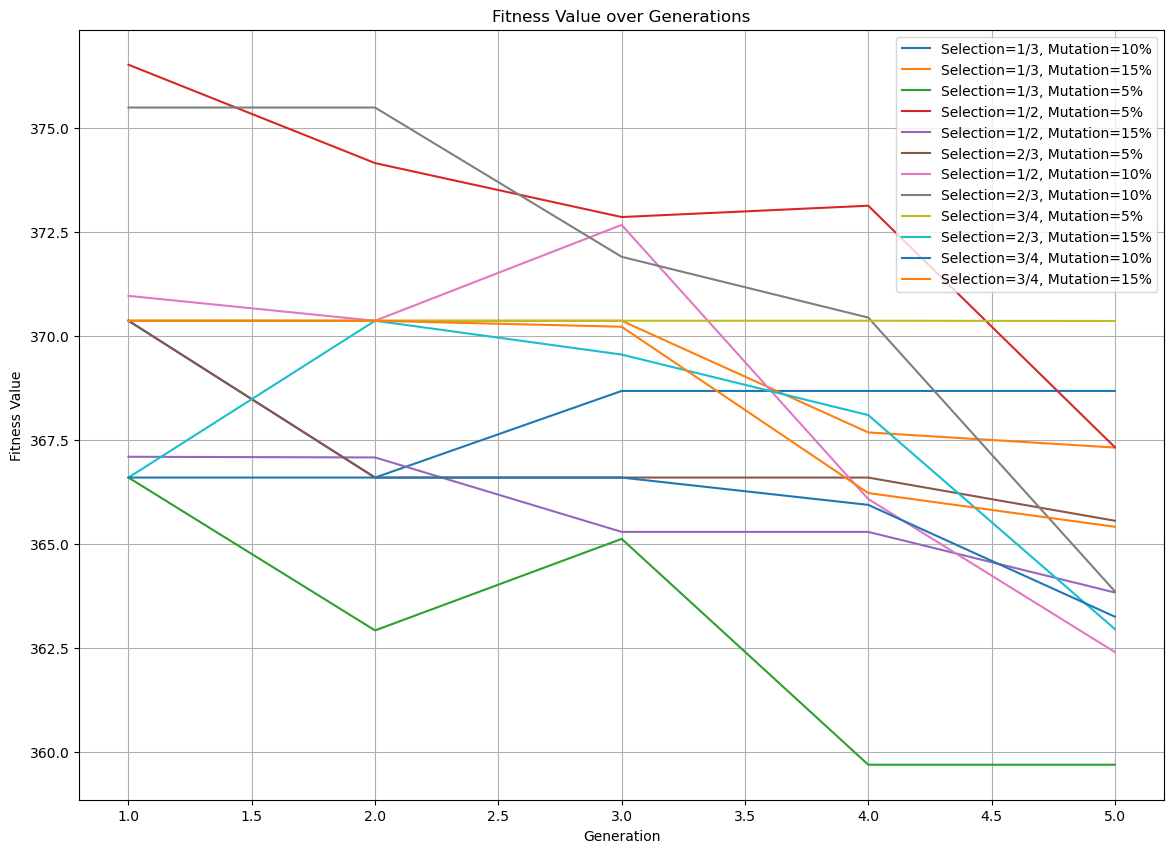

In [11]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from tqdm.notebook import tqdm
import os
import python_codes.ga_utils as ga  # 调整后的导入路径

# 读取图和位置信息
filename1 = "ATT_US_Norm"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 创建个体和适应度
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# 注册工具箱
toolbox = base.Toolbox()
toolbox.register("individual", ga.init_individual, read_graph=read_graph, edge_weights=edge_weights,
                 num_edges=num_edges)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", ga.evaluate, read_graph=read_graph, read_pos=read_pos, edge_weights=edge_weights)
toolbox.register("mate", ga.cxGraph, num_edges=num_edges)
toolbox.register("mutate", ga.mutGraph, num_edges=num_edges)
toolbox.register("select", tools.selTournament, tournsize=3)


# 主遗传算法流程
def main(population_size, selection_ratio, mutpb, initial_population, pbar, num_generations):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    cxpb = 0.5
    pop = initial_population[:]
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(num_generations):
        selected = toolbox.select(pop, num_selected)
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]
        pop[:] = selected + offspring
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        pbar.update(1)
        hof.update(pop)

    return logbook, hof[0].fitness.values[0]


# 参数配置
num_generations = 5
population_sizes = [300]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.05, 0.1, 0.15]
progress_bars = {
    pop_size: tqdm(total=12 * num_generations, desc=f'Population={pop_size}', position=i, leave=True)
    for i, pop_size in enumerate(population_sizes)
}

# 执行主流程
initial_population = toolbox.population(n=population_sizes[0])
fitnesses = list(map(toolbox.evaluate, initial_population))
initial_fitness = min(fitnesses)[0]
all_logbooks = []

# 执行每个种群大小的实验并绘图
for population_size in population_sizes:
    initial_population = toolbox.population(n=population_size)
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, initial_population,
                            progress_bars[population_size], num_generations): (
                selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            try:
                logbook, final_fitness = future.result()
                all_logbooks.append((logbook, selection_ratio, mutpb))

                print(
                    f'Completed: Pop={population_size}, Select={selection_ratio}, Mutate={mutpb} - Final Fitness={final_fitness}')

            except Exception as ex:
                print(f'Error with Pop={population_size}, Select={selection_ratio}, Mutate={mutpb}: {ex}')

plt.figure(figsize=(14, 10))
for logbook, selection_ratio, mutpb in all_logbooks:
    min_fitness_values = logbook.select("min")
    generations = list(range(1, len(min_fitness_values) + 1))
    fitness_values = [initial_fitness] + min_fitness_values
    generations = [0] + generations

    plt.plot(generations, fitness_values,
             label=f'Selection={Fraction(selection_ratio).limit_denominator()}, Mutation={int(mutpb * 100)}%')

plt.title("Fitness Value over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.legend()
plt.grid(True)
plt.show()


原始网络的最短路径和: 383.05722914981766


Population=300:   0%|          | 0/60 [00:00<?, ?it/s]

Completed: Pop=300, Select=0.3333333333333333, Mutate=0.1 - Final Fitness=363.44548618219505
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.05 - Final Fitness=366.5953158056469
Completed: Pop=300, Select=0.3333333333333333, Mutate=0.15 - Final Fitness=372.27945980668915
Completed: Pop=300, Select=0.5, Mutate=0.05 - Final Fitness=366.1950584847163
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.05 - Final Fitness=363.3434284847261
Completed: Pop=300, Select=0.5, Mutate=0.1 - Final Fitness=371.26422346502966
Completed: Pop=300, Select=0.5, Mutate=0.15 - Final Fitness=359.023302050775
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.1 - Final Fitness=366.0214030192914
Completed: Pop=300, Select=0.6666666666666666, Mutate=0.15 - Final Fitness=365.4046962450449
Completed: Pop=300, Select=0.75, Mutate=0.1 - Final Fitness=370.7417665988862
Completed: Pop=300, Select=0.75, Mutate=0.05 - Final Fitness=368.4076273961109
Completed: Pop=300, Select=0.75, Mutate=0.15 - Final

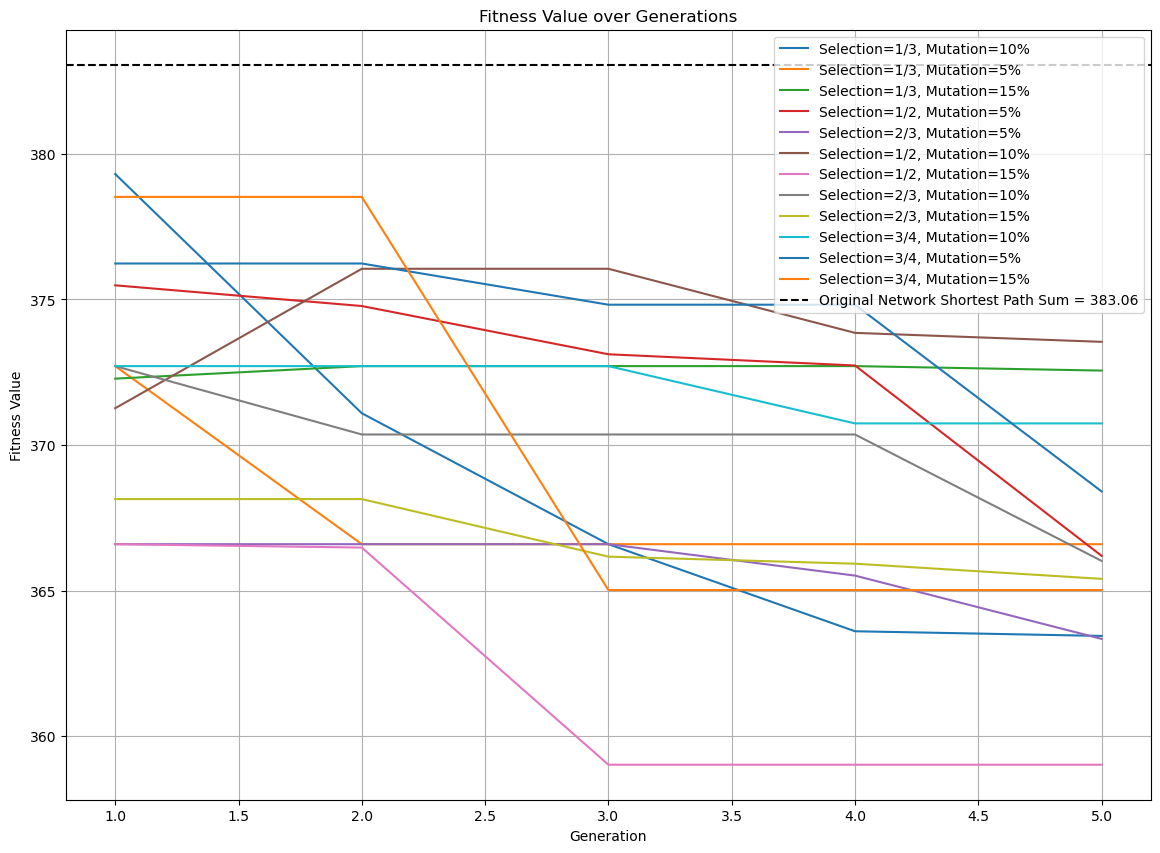

In [12]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from tqdm.notebook import tqdm
import os
import python_codes.ga_utils as ga  # 调整后的导入路径

# 读取图和位置信息
filename1 = "ATT_US_Norm"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 计算原始网络的最短路径和
dist_matrix = shortest_distance(read_graph, weights=edge_weights).get_2d_array(range(read_graph.num_vertices()))
original_network_value = np.sum(dist_matrix[dist_matrix != np.inf])
print(f"原始网络的最短路径和: {original_network_value}")

# 创建个体和适应度
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# 注册工具箱
toolbox = base.Toolbox()
toolbox.register("individual", ga.init_individual, read_graph=read_graph, edge_weights=edge_weights, num_edges=num_edges)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", ga.evaluate, read_graph=read_graph, read_pos=read_pos, edge_weights=edge_weights)
toolbox.register("mate", ga.cxGraph, num_edges=num_edges)
toolbox.register("mutate", ga.mutGraph, num_edges=num_edges)
toolbox.register("select", tools.selTournament, tournsize=3)

# 主遗传算法流程
def main(population_size, selection_ratio, mutpb, initial_population, pbar, num_generations):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    cxpb = 0.5
    pop = initial_population[:]
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(num_generations):
        selected = toolbox.select(pop, num_selected)
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]
        pop[:] = selected + offspring
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        pbar.update(1)
        hof.update(pop)

    return logbook, hof[0].fitness.values[0]

# 参数配置
num_generations = 5
population_sizes = [300]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.05, 0.1, 0.15]
progress_bars = {
    pop_size: tqdm(total=12 * num_generations, desc=f'Population={pop_size}', position=i, leave=True)
    for i, pop_size in enumerate(population_sizes)
}

# 执行主流程
initial_population = toolbox.population(n=population_sizes[0])
fitnesses = list(map(toolbox.evaluate, initial_population))
initial_fitness = min(fitnesses)[0]
all_logbooks = []

# 执行每个种群大小的实验并绘图
for population_size in population_sizes:
    initial_population = toolbox.population(n=population_size)
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, initial_population,
                            progress_bars[population_size], num_generations): (
                selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            try:
                logbook, final_fitness = future.result()
                all_logbooks.append((logbook, selection_ratio, mutpb))

                print(f'Completed: Pop={population_size}, Select={selection_ratio}, Mutate={mutpb} - Final Fitness={final_fitness}')

            except Exception as ex:
                print(f'Error with Pop={population_size}, Select={selection_ratio}, Mutate={mutpb}: {ex}')

# 绘制适应度值随代数的变化图
plt.figure(figsize=(14, 10))
for logbook, selection_ratio, mutpb in all_logbooks:
    min_fitness_values = logbook.select("min")
    generations = list(range(1, len(min_fitness_values) + 1))
    fitness_values = [initial_fitness] + min_fitness_values
    generations = [0] + generations

    plt.plot(generations, fitness_values, label=f'Selection={Fraction(selection_ratio).limit_denominator()}, Mutation={int(mutpb * 100)}%')

# 在图表上添加原始网络的最短路径和
plt.axhline(y=original_network_value, color='k', linestyle='--', label=f'Original Network Shortest Path Sum = {original_network_value:.2f}')
plt.title("Fitness Value over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.legend()
plt.grid(True)
plt.show()
